# Projet Décision dans l'incertain

## Déscriptif du projet: 

Bayesian Inverse Reinforcement Learning : This project aims to code in Python a Bayesian approach to the Inverse Reinforcement Learning
(IRL) problem. In the IRL problem, we try to learn the reward function R optimized by an agent called the tutor, given a partially described infinite horizon MDP ⟨S, A, T, γ⟩ (partially described because the reward function is not given), and observed state-action pairs O = {(si, ai)|i ∈ [M]} (with M ∈ N) realized by the tutor.


## Imports: 

In [1]:
!pip install pygame

In [1]:
import numpy as np
import random
from numpy.random import default_rng
import pygame
import time
import os
import matplotlib.pyplot as plt

pygame 2.5.2 (SDL 2.28.3, Python 3.9.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Réponses aux questions: 

### Question 1-7 : 

In [2]:
# ================================== Question 1 : =======================================================
class MDP:
    """
    Classe représentant un problème de décision markovien partiel.
    """
    # Question 1
    def __init__(self, size, init_state, nb_features = 5, discount = 0.9):
        """
        size : Taille de l'environnement (grille carrée de size x size).
        init_state : État initial de l'agent (position dans la grille).
        nb_features : Nombre de caractéristiques (features) dans chaque cellule de la grille.
        discount : Facteur de réduction utilisé pour la valeur des récompenses futures.
        """
        # chaque cellule represente un vecteur ; presence des features (States)
        self.env = np.zeros((size, size, nb_features)) 
        # Liste des actions possibles : Up (U), Left (L), Down (D), Right (R).
        self.actions = ["U", "L", "D", "R"] 
        self.discount = discount
        # Paires d'etat-action observées/effectuées par l'agent.
        self.observations = [] 
        # A apprendre par l'agent
        self.rewards = None 
        # Valeurs maximales et minimales des récompenses.
        self.RMAX = 10
        self.RMIN = -10
        # Etat courant de l'agent
        self.current_state = init_state
        self.probabilities = [0.8, 0.5] #   Première proba : probabilité d'effectuer le bon mouvement
                                        #   Deuxième proba: si n'effectue pas le bon mouvement, proba d'effectuer le mouvement à gauche de la direction voulue.

        # Pour chaque cellule (i, j) et chaque action, calcule les nouvelles positions selon les probabilités de mouvement et met à jour la matrice de transition T.
        T = np.zeros((len(self.env) ** 2, len(self.actions), len(self.env) ** 2))
        for i in range(len(self.env)):
            for j in range(len(self.env)):
                for action_index in range(len(self.actions)):
                    # (i,j) represente l'état du joueur
                    action = self.actions[action_index]
                    i_next, j_next = self.move_towards((i, j), action) 
                    # T((i,j), action, (i_next, j_next))
                    T[i * len(self.env) + j, action_index, i_next * len(self.env) + j_next] = self.probabilities[0]
                    proba_other_move = (1 - self.probabilities[0]) * self.probabilities[1]
                    if action in {"U" , "D"}:
                        i_left, j_left = self.move_towards((i, j), "L")
                        i_right, j_right = self.move_towards((i, j),"R")
                        T[i * len(self.env) + j, action_index, i_left * len(self.env) + j_left] += proba_other_move
                        T[i * len(self.env) + j, action_index, i_right * len(self.env) + j_right] += proba_other_move
                    else:
                        i_up, j_up = self.move_towards((i, j),"U")
                        i_down, j_down = self.move_towards((i, j),"D")
                        T[i * len(self.env) + j, action_index, i_up * len(self.env) + j_up] += proba_other_move
                        T[i * len(self.env) + j, action_index, i_down * len(self.env) + j_down] += proba_other_move

        # Initialise la matrice de transition T qui stocke les probabilités de transition d'un état à un autre pour chaque action.
        self.T = T

    def move_towards(self, state, move):
        """
        Arguments:
        state : Position actuelle (tuple (i, j)).
        move : Mouvement à effectuer ("L", "R", "U", "D").
        
        Retourne:
        Cette méthode retourne la nouvelle position après avoir effectué le mouvement, en tenant compte des bords de la grille.
        """
        if move == "L":
            if state[1] == 0:
                return state
            return state[0], state[1] - 1
        if move == "R":
            if state[1] == len(self.env) - 1:
                return state
            return state[0], state[1] + 1
        if move == "U":
            if state[0] == 0:
                return state
            return state[0] - 1, state[1]
        if move == "D":
            if state[0] == len(self.env) - 1:
                return state
            return state[0] + 1, state[1]
            
    #def move_towards(self, move):
    #    return self.move_towards(current_state, move)
    
    def agent(self, position, action):
        """
        Arguments:
        position : Position actuelle de l'agent.
        action : Action à effectuer (peut être un index ou une chaîne de caractères).
        
        Retourne:
        Cette méthode détermine si l'agent effectue le mouvement correct ou un mouvement incorrect, puis retourne la nouvelle position.
        """
        # Si l'action n'est pas une chaîne de caractères, on récupère l'action correspondante à partir de l'index.
        if not isinstance(action, str):
            action = self.actions[action] # Je le mets en string
        # Convertit l'action en majuscules pour uniformiser le traitement.
        action = action.upper()
        # Tire un nombre aléatoire et vérifie si l'agent effectue le mouvement souhaité.
        good_direction = random.random() < self.probabilities[0]
        if good_direction:
             # Si le mouvement est effectué correctement, on retourne la nouvelle position après le mouvement.
            return self.move_towards(position, action)
        # Si l'agent n'effectue pas le mouvement correct, tire un autre nombre aléatoire pour décider du mouvement incorrect ; opposé ou reste sur le meme état
        good_direction = random.random() < self.probabilities[1]
        index_action = self.actions.index(action) # Récupère l'index de l'action actuelle.
        if good_direction:
            # Si le mouvement incorrect est choisi selon la deuxième probabilité,
            # l'action devient celle à gauche de la direction souhaitée (dans la liste d'actions).
            action = self.actions[(index_action - 1) % len(self.actions)]
        else:
            # Sinon, l'action devient celle à droite de la direction souhaitée.
            action = self.actions[(index_action + 1) % len(self.actions)]
        return self.move_towards(position , action)
                
    # ================================== Question 3 : =======================================================
    def randomized(size, vector): 
        """
        Méthode statique qui crée un objet MDP avec des caractéristiques aléatoires placées dans l'environnement.

        Arguments:
        - size: Taille de l'environnement (grille carrée de size x size).
        - vector: Liste de nombres représentant le nombre de chaque caractéristique (feature) à placer dans la grille.

        Retourne:
        - Un objet MDP initialisé avec des caractéristiques aléatoires.
        """
        # Génère une position initiale aléatoire (i, j) pour l'agent, où i et j sont des entiers entre 0 et size-1.
        init = tuple(np.random.randint(0, size, 2))
        mdp = MDP(size, init)
        rng = default_rng()
        choices = []
        for i in range(size): 
            for j in range (size): 
                choices.append((i, j))
        rng = default_rng()
        # Pour chaque caractéristique (représentée par son index k dans le vector), 
        # sélectionne un nombre de positions aléatoires égal à vector[k] sans remplacement.
        # Place la caractéristique k dans les positions sélectionnées en définissant mdp.env[i, j, k] à 1 pour chaque position (i, j).
        for k in range(0, len(vector)):
            numbers = rng.choice(choices, size = vector[k], replace=False)
            for i, j in numbers:
                mdp.env[i, j, k] = 1
        return mdp
    
    def format_cell(self, row, col):
        """
        Formate une cellule donnée par l'utilisateur en indices manipulables par le programme.
        
        Arguments:
        - row: Le rang de la cellule (lettre, par exemple 'A', 'B', ...).
        - col: La colonne de la cellule (numéro, par exemple '1', '2', ...).

        Retourne:
        - Un tuple d'indices (i, j) représentant la position formatée de la cellule dans la grille.
        """
        # Convertit le rang de la cellule en majuscule pour uniformiser le traitement.
        row = row.upper()
        
        # Si la colonne est donnée sous forme de chaîne de caractères, la convertir en entier.
        if isinstance(col, str):
            col = int(col)
        
        # Calcule l'indice de la ligne dans la grille :
        # ord(row) donne le code ASCII de la lettre de la ligne.
        # 65 est le code ASCII de 'A', donc 'A' -> 0, 'B' -> 1, etc.
        # On ajuste en soustrayant de la taille de la grille moins 1 pour inverser les indices,
        # car dans notre grille, 'A' correspond à la dernière ligne, 'B' à l'avant-dernière, etc.
        row_index = 65 + len(self.env[0]) - 1 - ord(row)
        
        # Calcule l'indice de la colonne dans la grille en soustrayant 1, car les indices des colonnes
        # de la grille sont zéro-indéxés (c'est-à-dire, la première colonne est l'index 0).
        col_index = col - 1
        
        # Retourne un tuple contenant les indices (i, j) formatés pour la grille.
        return row_index, col_index
    
    def format_index(self, row, col):
        """
        Formate un index de cellule du programme en cellule compréhensible pour l'utilisateur.
        
        Arguments:
        - row: L'indice de la rangée (entier, par exemple 0, 1, ...).
        - col: L'indice de la colonne (entier, par exemple 0, 1, ...).

        Retourne:
        - Une chaîne de caractères représentant la cellule dans un format compréhensible pour l'utilisateur
        (par exemple, 'A1', 'B2', ...).
        """
        # Convertit l'indice de la rangée en une lettre.
        # chr() convertit un code ASCII en son caractère correspondant.
        # len(self.env) donne la taille de la grille.
        # len(self.env) - row - 1 ajuste l'indice pour inverser l'ordre des rangées.
        # ord("A") donne le code ASCII de la lettre 'A', ce qui permet de calculer la lettre correspondante.
        row_char = chr(len(self.env) - row - 1 + ord("A"))
        
        # Convertit l'indice de la colonne en un numéro en ajoutant 1 (car les indices des colonnes sont zéro-indexés).
        col_num = str(col + 1)
        
        # Concatène la lettre de la rangée et le numéro de la colonne pour former la représentation utilisateur.
        return row_char + col_num

    def add_features(self, indice, cellules):
        """
        Ajoute un feature spécifique à des cellules données de l'environnement.
        
        Arguments:
        - indice: L'indice de la caractéristique à ajouter (entier).
        - cellules: Une liste de cellules où ajouter la caractéristique. Chaque cellule est représentée par un tuple (i, j) où i est l'indice de la rangée et j est l'indice de la colonne.
        
        Cette méthode ne retourne rien elle modifie l'environnement
        """
        # Parcourt chaque cellule dans la liste des cellules fournies.
        for cellule in cellules:
            # Accède à la cellule spécifiée dans l'environnement (self.env) et place la caractéristique en mettant la valeur à 1 à l'indice spécifié.
            self.env[cellule][indice] = 1

    # ==================================  Question 4 :  =======================================================
    def policy_iteration(self, R, starting_policy=None):
        """
        Applique Policy iteration avec une Reward function donnée.

        Arguments:
        - R: Reward function (matrice)
        - eps: Seuil de convergence.
        - starting_policy: Politique initiale (facultative).

        Retourne:
        - policy: Politique optimale trouvée.
        - v: Valeur des états pour la politique optimale.
        - Q: Valeur de la fonction Q pour la politique optimale.
        """
        # Initialisation de la politique
        if len(R.shape) > 1:
            R = R.flatten()  # Aplatir R si c'est une matrice

        if len(R) == self.env.shape[-1]:  
            # Le produit matriciel self.env @ R.T multiplie chaque vecteur de features de que cellule de self.env par le vecteur 
            # de récompenses R.T. Cette opération calcule la récompense totale pour chaque état (chaque cellule) en tenant compte 
            # de ses caractéristiques et des poids associés dans R.
            R = (self.env @ R.T).flatten()

        nb_states = len(R)  # Nombre total d'états
        policy = [0] * nb_states  # Initialiser la politique avec des actions par défaut (ici l'action 0)

        if starting_policy is not None:
            policy = starting_policy  # Utiliser la politique initiale fournie si disponible

        v = np.zeros(len(R))  # Initialiser les valeurs des états à zéro

        while True:
            old_policy = policy.copy()  # Copier la politique actuelle
            old_v = v  # Copier les valeurs actuelles des états

            # Évaluation de la politique
            b = R  # Les récompenses servent de vecteur de terme constant dans le système linéaire
            A = np.zeros((nb_states, nb_states))  # Initialiser la matrice A
            np.fill_diagonal(A, 1)  # Remplir la diagonale de A avec des 1

            # Ajuster la matrice A pour l'évaluation de la politique
            A = A - self.discount * self.T[np.arange(0, len(R)), policy]
            v = np.linalg.solve(A, b)  # Résoudre le système linéaire pour trouver les valeurs des états

            # Amélioration de la politique
            Q = (R + (self.discount * self.T @ v).T).T  # Calculer la fonction Q pour toutes les actions
            policy = np.argmax(Q, axis=1)  # Choisir la meilleure action pour chaque état

            # Vérifier la convergence de la politique
            if np.array_equal(policy, old_policy):
                break

        return policy, v, Q  # Retourner la politique optimale, les valeurs des états et la fonction Q

    # ==================================  Question 5 :  =======================================================
    def states_actions(self, R, M, s0):
        """
        Renvoie l'ensemble des paires états-actions.

        Arguments:
        - R: Vecteur de récompenses ou matrice de récompenses.
        - M: Nombre d'étapes à simuler.
        - s0: État initial .

        Retourne:
        - res: Liste des paires (état, action) représentant les états visités et les actions prises.
        """
        res = []  # Initialiser la liste des résultats.
        fail = True  
        policy = None  # La politique initiale est nulle.
        next_state = None  # Le prochain état est initialement nul.
        state_of_agent = s0  # L'état initial de l'agent est s0.

        while M != 0:  # Boucle tant qu'il reste des étapes à simuler.
            if fail:  # Si c'est le début ou si une erreur s'est produite, recalculer la politique.
                policy, _, _ = self.policy_iteration(R)  # Calculer la politique optimale.
                fail = False  # Réinitialiser l'indicateur d'échec.
            
            # Choisir une action en fonction de la politique avec une probabilité de 95 %,
            # ou choisir une action aléatoire avec une probabilité de 5 %.
            if random.random() <= 0.95:
                action = policy[state_of_agent[0] * len(self.env) + state_of_agent[1]]
            else:
                action = random.randint(0, 3)

            # Déterminer le prochain état après avoir pris l'action.
            next_state = self.agent(state_of_agent, action)
            row, col = next_state  # Décomposer le prochain état en rangée et colonne.
        
            # Ajouter la paire (état, action) à la liste des résultats, en formatant l'état pour l'affichage.
            res.append((self.format_index(row, col), self.actions[action]))
            
            M -= 1  # Décrémenter le compteur d'étapes.
            state_of_agent = next_state  # Mettre à jour l'état de l'agent pour la prochaine itération.
        self.observations = res
        return res  # Retourner la liste des paires états-actions.

    
    # ==================================  Question 6 :  =======================================================
    def likelihood(self, O, R, trust = 0.95):
        """
        Calcule la vraisemblance d'une série d'observations d'actions dans un environnement donné.

        Arguments:
        - O: Liste des paires (état, action) observées.
        - R: Vecteur de récompenses.
        - trust: Paramètre de confiance pour ajuster l'importance de Q dans la vraisemblance.

        Retourne:
        - res: La vraisemblance calculée des observations données les récompenses et la politique optimisée.
        """
        # Calculer les récompenses associées à chaque état en multipliant l'environnement par les récompenses transposées.
        rewards_states = self.env @ R.T
        
        # Effectuer une itération de politique pour obtenir la politique optimale, les valeurs des états et la fonction Q.
        policy, v, Q = self.policy_iteration(rewards_states)
        
        # Initialiser la vraisemblance à 1.
        res = 1
        
        # Pour chaque paire (état, action) dans les observations O :
        for state, action in O:
            # Convertir les indices de l'état formaté en indices manipulables par le programme.
            row, col = self.format_cell(state[0], state[1])
            
            # Calculer l'indice linéaire de l'état dans la matrice Q.
            index = row * Q.shape[-1] + col
            
            # Trouver l'indice de l'action dans la liste des actions possibles.
            action = self.actions.index(action)
            
            # Mettre à jour la vraisemblance en multipliant par la probabilité de l'action observée donnée l'état.
            res *= np.exp(trust * Q[index, action]) / np.sum(np.exp(trust * Q[index]))
    
        # Retourner la vraisemblance calculée.
        return res

    def prior_gaussian(self, R, parameters):
        """
        Calcule la probabilité a priori d'un vecteur de récompenses R selon une distribution gaussienne.

        Arguments:
        - R: Vecteur de récompenses.
        - parameters: Liste contenant les paramètres de la distribution, ici l'écart-type (std).

        Retourne:
        - La probabilité a priori calculée pour le vecteur R.
        """
        std = parameters[0]  # Écart-type de la distribution gaussienne.
        
        # Calcule la probabilité a priori selon la distribution gaussienne.
        return (1 / (np.sqrt(2 * np.pi) * std)) * np.prod(np.exp(-(R ** 2) / (2 * (std ** 2))))

    def prior_uniform(self, R, parameters):
        """
        Calcule la probabilité a priori d'un vecteur de récompenses R selon une distribution uniforme.

        Arguments:
        - R: Vecteur de récompenses.
        - parameters: Liste contenant les paramètres de la distribution, ici Rmax et Rmin.

        Retourne:
        - La probabilité a priori calculée pour le vecteur R.
        """
        Rmax, Rmin = parameters  # Les bornes de la distribution uniforme.
        
        # Calcule la probabilité a priori selon la distribution uniforme.
        return 1 / (self.env.shape[-1] ** (Rmax - Rmin + 1))

    def bayesian_framework(self, R1, R2, O, prior, parameters, trust=0.95):
        """
        Applique le cadre bayésien pour comparer deux vecteurs de récompenses R1 et R2.

        Arguments:
        - R1: Premier vecteur de récompenses.
        - R2: Deuxième vecteur de récompenses.
        - O: Observations sous forme de paires (état, action).
        - prior: Fonction de probabilité a priori à utiliser (e.g., prior_gaussian ou prior_uniform).
        - parameters: Paramètres pour la fonction de probabilité a priori.
        - trust: Paramètre de confiance pour ajuster l'importance de Q dans la vraisemblance (par défaut 0.95).

        Retourne:
        - Le rapport des vraisemblances bayésiennes des deux vecteurs de récompenses.
        """
        R1 = np.array(R1)
        R2 = np.array(R2)
        O = np.array(O)

        # Calcule la vraisemblance des observations pour R1 et R2, et multiplie par les probabilités a priori respectives.
        likelihood_R1 = self.likelihood(O, R1, trust) * prior(R1, parameters)
        likelihood_R2 = self.likelihood(O, R2, trust) * prior(R2, parameters)

        # Retourne le rapport des vraisemblances bayésiennes.
        return likelihood_R1 / likelihood_R2
        
    # ==================================  Question 7 :  =======================================================
    def one_neighbor(self, R, stepsize):
        """
        Génère un "voisin" du vecteur de récompenses R en modifiant une de ses composantes.

        Arguments:
        - R: Vecteur de récompenses.
        - stepsize: Taille de l'étape de modification.

        Retourne:
        - res: Nouveau vecteur de récompenses après modification d'une composante.
        """
        # Crée une copie du vecteur de récompenses pour éviter de modifier l'original.
        res = np.copy(R)
        # Sélectionne un index aléatoire dans le vecteur de récompenses.
        index = np.random.randint(0, len(R))
        # Boucle jusqu'à ce qu'un index soit trouvé dont la valeur n'est ni RMAX ni RMIN.
        while res[index] in {self.RMAX, self.RMIN}:
            index = np.random.randint(0, len(R))
        # Modifie la valeur à l'index sélectionné en l'incrémentant ou la décrémentant
        # de la valeur stepsize. Le signe de la modification est déterminé aléatoirement.
        res[index] += ((-1) ** np.random.randint(1, 3)) * stepsize
        
        # Retourne le nouveau vecteur de récompenses.
        return res

    def policy_walk(self, stepsize=1, max_iter=100):
        """
        Trouve le reward optimal.

        Arguments:
        - stepsize: Taille de l'étape pour la modification des récompenses.
        - max_iter: Nombre maximal d'itérations .

        Retourne:
        - R: Vecteur de récompenses optimal trouvé.
        """
        # Définir le domaine des valeurs possibles pour les récompenses.
        domain = np.arange(self.RMIN, self.RMAX, stepsize)
        # Initialiser aléatoirement un vecteur de récompenses R dans le domaine défini.
        R = np.random.choice(domain, self.env.shape[-1])
        # Calculer la politique initiale, les valeurs des états et la fonction Q pour R.
        policy, v, Q = self.policy_iteration(R)
        # Calculer les récompenses pour chaque état en utilisant R.
        rewards_states = (self.env @ R.T).flatten()
        # Boucle principale jusqu'à atteindre le nombre maximal d'itérations.
        max_reward = R # Reward maximisant la probabilité à posteriori
        max_reward_value = 0
        O = self.observations
        while max_iter != 0:
            # Générer un voisin de R en modifiant une de ses composantes.
            R_neighbor = self.one_neighbor(R, stepsize)
            # Calculer les récompenses pour chaque état en utilisant R_neighbor.
            rewards_states_neighbor = (self.env @ R_neighbor.T).flatten()
            # Calculer la nouvelle valeur Q en ajustant les récompenses.
            Q_value = (-rewards_states + rewards_states_neighbor + Q.T).T # On enlève les anciences reward, et on rajouter les nouveaux reward
            # Extraire les valeurs Q pour la politique actuelle.
            Q_policy = Q_value[np.arange(len(Q_value)), policy]
            ratio_posterior = self.bayesian_framework(R_neighbor, R, O, self.prior_uniform, [self.RMIN, self.RMAX])
            if ratio_posterior > 1: #On considère le likelihood le plus grand
                posterior_value = self.likelihood(O, R_neighbor) * self.prior_uniform(R_neighbor, [self.RMIN, self.RMAX])
                reward_with_posterior = R_neighbor
            else:
                posterior_value = self.likelihood(O, R) * self.prior_uniform(R, [self.RMIN, self.RMAX])
                reward_with_posterior = R
            if posterior_value > max_reward_value:
                max_reward_value = posterior_value
                max_reward = reward_with_posterior
            # Si une action dans l'ancienne politique est pire que la nouvelle:
            if np.any(Q_policy < Q.T):
                # Recalculer la politique avec le voisin R_neighbor en utilisant la politique actuelle comme point de départ.
                policy_neighbor, _, _ = self.policy_iteration(R_neighbor, starting_policy=policy)
                # Appliquer le cadre bayésien pour décider d'accepter ou non la nouvelle politique.
                if min(1, ratio_posterior) >= np.random.uniform(0, 1):
                    policy = policy_neighbor  # Mettre à jour la politique.
                    R = R_neighbor  # Mettre à jour le vecteur de récompenses.
                    rewards_states = rewards_states_neighbor  # Mettre à jour les récompenses des états.
            else:
                # Si aucune action n'est pire, appliquer directement le cadre bayésien.
                if min(1, ratio_posterior) >= np.random.uniform(0, 1):
                    R = R_neighbor  # Mettre à jour le vecteur de récompenses.
                    rewards_states = rewards_states_neighbor  # Mettre à jour les récompenses des états.
            max_iter -= 1  # Décrémenter le compteur d'itérations.

        return max_reward  # Retourner le vecteur de récompenses optimal trouvé.

    # ====================================================================================================
    def create_rewards(self):
        """
        Crée et assigne un vecteur de récompenses à l'environnement en utilisant des coefficients prédéfinis.

        Arguments:
        - Aucun

        Effets:
        - Initialise self.coeffs avec des valeurs prédéfinies.
        - Calcule et initialise self.rewards en utilisant les coefficients et l'environnement.
        """
        # Initialiser un tableau de coefficients avec des valeurs par défaut de 1.
        coeffs = np.ones(5)
        
        # Définir des coefficients spécifiques pour certaines caractéristiques.
        coeffs[0] = 10 
        coeffs[4] = -1  
        coeffs[1] = -5  
        coeffs[2] = -2  
        coeffs[3] = -1  
    
        # Assigner les coefficients au membre de classe self.coeffs.
        self.coeffs = coeffs
        
        # Calculer les récompenses pour chaque état en utilisant le produit matriciel de l'environnement et des coefficients.
        self.rewards = (self.env @ coeffs.T).flatten()

# ====================================================================================================
    def affichage(self):
        """
        Affiche l'environnement et la position actuelle de l'agent en utilisant Pygame.

        Arguments:
        - Aucun

        Effets:
        - Initialise une fenêtre Pygame.
        - Affiche la grille de l'environnement avec les caractéristiques et la position de l'agent.
        - Met à jour la position de l'agent en fonction de la politique calculée.
        - Gère les événements de fermeture de la fenêtre et de déplacement manuel de l'agent.
        """
        # Initialisation de Pygame
        pygame.init()
        
        # Couleurs
        BLANC = (255, 255, 255)
        
        # Chemin du répertoire des logos
        current_dir = os.getcwd()  # Utiliser le répertoire de travail courant
        logo_dir = os.path.join(current_dir, 'logo')
        
        # Chargement des logos des features
        logo_paths = {
            1: os.path.join(logo_dir, "Treasure.png"),
            2: os.path.join(logo_dir, "Bomb.png"),
            3: os.path.join(logo_dir, "Mud.png"),
            4: os.path.join(logo_dir, "Water.png"),
            5: os.path.join(logo_dir, "Montain.png"),
            6: os.path.join(logo_dir, "MoreThanOne.png")
        }
        
        # Déterminer les dimensions de la grille et des cases
        largeur_carte = len(self.env[0])
        hauteur_carte = len(self.env[0])
        taille_case = 75
        
        # Taille de la fenêtre
        largeur_fenetre = largeur_carte * taille_case
        hauteur_fenetre = hauteur_carte * taille_case
        
        # Initialisation de la fenêtre Pygame
        fenetre = pygame.display.set_mode((largeur_fenetre, hauteur_fenetre))
        
        # Création des récompenses et calcul de la politique initiale
        self.create_rewards()
        policy, v, _ = self.policy_iteration(self.rewards)
        
        # Boucle principale
        continuer = True
        while continuer:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    continuer = False  # Quitter la boucle si l'utilisateur ferme la fenêtre
                if event.type == pygame.KEYDOWN:
                    # Gestion des touches de direction pour déplacer l'agent manuellement
                    if event.key == pygame.K_LEFT:
                        self.current_state = self.move_towards(self.current_state, "L")
                    if event.key == pygame.K_RIGHT:
                        self.current_state = self.move_towards(self.current_state, "R")
                    if event.key == pygame.K_UP:
                        self.current_state = self.move_towards(self.current_state, "U")
                    if event.key == pygame.K_DOWN:
                        self.current_state = self.move_towards(self.current_state, "D")
            
            # Mettre à jour l'état actuel de l'agent en suivant la politique optimale
            self.current_state = self.move_towards(
                self.current_state, 
                self.actions[policy[self.current_state[0] * len(self.env) + self.current_state[1]]]
            )
            
            # Effacer l'écran
            fenetre.fill(BLANC)
            
            # Afficher la position actuelle du robot
            robot_logo_path = os.path.join(logo_dir, "Robot.png")
            logo = pygame.image.load(robot_logo_path)
            logo = pygame.transform.scale(logo, (taille_case, taille_case))
            fenetre.blit(logo, (self.current_state[1] * taille_case, self.current_state[0] * taille_case))
            
            # Afficher la carte avec les features
            for i in range(hauteur_carte):
                for j in range(largeur_carte):
                    if np.sum(self.env[i][j]) == 0: 
                        continue  # Ne rien faire si la cellule est vide
                    else:  
                        # Déterminer le logo à afficher
                        if np.sum(self.env[i][j]) > 1: 
                            indice = 6  # MoreThanOne.png si plus d'une caractéristique présente
                        else: 
                            indice = np.argmax(self.env[i][j]) + 1  # Sinon, l'indice de la caractéristique présente

                        # Charger et afficher le logo correspondant
                        logo_path = logo_paths[indice]
                        logo = pygame.image.load(logo_path)
                        logo = pygame.transform.scale(logo, (taille_case, taille_case))
                        fenetre.blit(logo, (j * taille_case, i * taille_case))
            
            # Rafraîchir l'affichage
            pygame.display.update()
            
            # Attendre 1 seconde avant de mettre à jour à nouveau
            time.sleep(1)
        
        # Quitter Pygame
        pygame.quit()





In [3]:
# ==================================  Question 2 :  =======================================================
example = MDP(9, (4,6))
# 0 = Trésor
# 1 = Bombe
# 2 = Mud
# 3 = Water
# 4 = Montagne
example.add_features(3, [(1,0), (1,1),(1,2),(2,0),(2,1),(2,2) ])
example.add_features(2, [(0,2), (0,5),(1,5),(6,2),(7,2),(6,5), (7,5) ])
example.add_features(1, [(1,3), (2,6),(5,2) ])
example.add_features(0, [(7, 0) ])
example.add_features(4, [(4,2), (4,3),(4,4),(5,2),(5,3),(5,4)])

example.create_rewards()
O = example.states_actions(example.rewards, 11, example.current_state)
example.observations
policy, _, Q = example.policy_iteration(example.rewards)

### Test :  

In [13]:
example.policy_walk(max_iter = 70)

array([  2,   0,  -2, -10,  -1])

La valeur trouvée se rapproche assez du vrais reward pour certains indices.

In [6]:
example.prior_gaussian(np.array([0, 0, 0,0, 0]), [0.1])

3.989422804014327

In [7]:
example.likelihood(O, np.array([-10, -1, -5, -2, -1]), 4)

3.043508086873082e-13

In [8]:
example.bayesian_framework([10, 5, 3, 2, 1], [4, 5, 6, 7, 4], O, example.prior_uniform, [1, -1])

29588.29292274732

In [9]:
example.affichage()

In [10]:
example2 = MDP.randomized(12, [1, 20, 14, 7, 8])
example2.affichage()

In [11]:
example.env[0]

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [14]:
coeffs = np.ones(5)
coeffs[0] = 10
coeffs[4] = -1
coeffs[1] = -5
coeffs[2] = -2
coeffs[3] = -1
rewards = (example.env @ coeffs.T).flatten()

In [15]:
rewards

array([ 0.,  0., -2.,  0.,  0., -2.,  0.,  0.,  0., -1., -1., -1., -5.,
        0., -2.,  0.,  0.,  0., -1., -1., -1.,  0.,  0.,  0., -5.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,
       -1., -1.,  0.,  0.,  0.,  0.,  0.,  0., -6., -1., -1.,  0.,  0.,
        0.,  0.,  0.,  0., -2.,  0.,  0., -2.,  0.,  0.,  0., 10.,  0.,
       -2.,  0.,  0., -2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.])

In [17]:
policy, v, _= example.policy_iteration(rewards)

In [18]:
import matplotlib.pyplot as plt
v

array([27.97159408, 25.31385368, 20.31860995, 17.93749847, 17.51603096,
       13.25514378, 12.24146291, 11.66858789, 10.87152994, 32.18875525,
       29.1218546 , 25.15511566, 18.8191605 , 20.4287405 , 16.11820607,
       13.88656537, 13.31724796, 12.28183241, 38.43166717, 34.66792531,
       30.33392264, 27.38418535, 24.00607987, 20.87476186, 13.10805927,
       15.225128  , 13.85821552, 45.62875534, 40.94308642, 35.76282317,
       31.24109045, 27.23199751, 23.77495344, 20.3159983 , 17.77522676,
       15.61210361, 52.55179109, 46.69145049, 39.48608794, 33.63645643,
       28.64294666, 25.43540738, 22.42562765, 19.74940517, 17.40778834,
       60.58319354, 53.34450192, 40.55099439, 37.71972195, 33.04242506,
       28.9433829 , 25.37438327, 22.25758721, 19.53283461, 69.90236243,
       61.35968915, 50.9911678 , 44.57821417, 38.9482578 , 31.81833554,
       27.96490097, 24.56205323, 21.5630097 , 80.67885804, 69.21092252,
       57.36224574, 49.6644264 , 43.09028166, 35.22983842, 30.80

In [19]:
policy

array([2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2,
       1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1,
       2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

### Question 9 : 

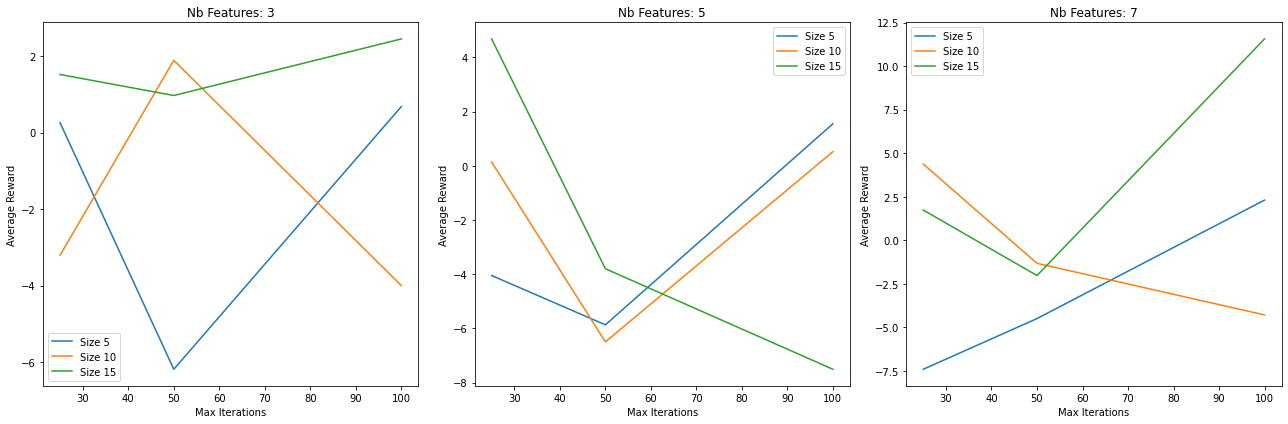

In [14]:
# Définir les tailles des MDPs à tester
sizes = [5, 10, 15]
# Définir le nombre de caractéristiques à tester
nb_features_list = [3, 5, 7]
# Définir le nombre d'itérations pour PolicyWalk
max_iters = [25, 50, 100]
# Taille de l'étape pour PolicyWalk
stepsize = 0.1

def run_experiments():
    """
    Exécute des expériences sur des MDPs de tailles, nombres de caractéristiques et itérations différents.
    
    Retourne:
    - results: Un dictionnaire avec comme clés les tuples (size, nb_features, max_iter) et comme valeurs
               la récompense moyenne obtenue après plusieurs exécutions de PolicyWalk.
    """
    results = {}
    for size in sizes:
        for nb_features in nb_features_list:
            for max_iter in max_iters:
                key = (size, nb_features, max_iter)
                rewards = []
                for _ in range(10):  # Faire plusieurs runs pour lisser les résultats
                    # Initialiser un état initial aléatoire
                    init_state = (np.random.randint(0, size), np.random.randint(0, size))
                    mdp = MDP(size, init_state, nb_features)
                    # Exécuter PolicyWalk et obtenir le vecteur de récompenses
                    reward = mdp.policy_walk(stepsize, max_iter)
                    # Ajouter la somme des récompenses obtenues
                    rewards.append(np.sum(reward))
                # Calculer la récompense moyenne pour cette configuration
                avg_reward = np.mean(rewards)
                # Stocker le résultat dans le dictionnaire
                results[key] = avg_reward
    return results

# Exécuter les expériences
results = run_experiments()

# Convertir les résultats en un format facile à manipuler pour les plots
data = []
for key, reward in results.items():
    size, nb_features, max_iter = key
    data.append([size, nb_features, max_iter, reward])

data = np.array(data)

def plot_results(data):
    """
    Crée des graphiques montrant la performance des algorithmes en fonction des paramètres testés.

    Arguments:
    - data: Un tableau NumPy contenant les données à tracer.
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    for i, nb_features in enumerate(nb_features_list):
        ax = axes[i]
        subset = data[data[:, 1] == nb_features]
        for size in sizes:
            subsubset = subset[subset[:, 0] == size]
            ax.plot(subsubset[:, 2], subsubset[:, 3], label=f'Size {size}')
        ax.set_title(f'Nb Features: {nb_features}')
        ax.set_xlabel('Max Iterations')
        ax.set_ylabel('Average Reward')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

# Afficher les résultats
plot_results(data)
